# Introduction

## Problem Statement

> The current RFM model does not capture customer demographics well.

## Goal Statement

> To develop a customer segmentation model that captures customer demographics and can be used to target customers with more relevant marketing campaigns.

# Technical Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
%matplotlib inline
plt.style.use('bmh')

from datetime import datetime
import functools
import gc
from umap import validation



# stats packages
import scipy.stats as stats
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn import metrics
from sklearn import preprocessing

from denseclus import DenseClus

# Data Collection

In [2]:
df = pd.read_csv('data\df_clean.csv')

print(df.shape)

(2193, 42)


In [3]:
df

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedAnyCmp,Engagement_Rate,Total_Purchases,Total_Spending,Spend_per_Purchase,Recency_Score,Frequency_Score,Monetary_Score,Avg_RFM,RFM_Segment
0,Bachelor's Degree,Single,58138.0,0,0,58,635,88,546,172,...,1,16.666667,25,1617,64.680000,3,5,5,4.333333,Champions
1,Bachelor's Degree,Single,46344.0,1,1,38,11,1,6,2,...,0,0.000000,6,27,4.500000,4,1,1,2.000000,New
2,Bachelor's Degree,Together,71613.0,0,0,26,426,49,127,111,...,0,0.000000,21,776,36.952381,4,4,4,4.000000,Champions
3,Bachelor's Degree,Together,26646.0,1,0,26,11,4,20,10,...,0,0.000000,8,53,6.625000,4,2,1,2.333333,New
4,Doctorate Degree,Married,58293.0,1,0,94,173,43,118,46,...,0,0.000000,19,422,22.210526,1,4,3,2.666667,Can't Lose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2188,Bachelor's Degree,Married,61223.0,0,1,46,709,43,182,42,...,0,0.000000,18,1341,74.500000,3,4,5,4.000000,Champions
2189,Doctorate Degree,Together,64014.0,2,1,56,406,0,30,0,...,1,16.666667,22,444,20.181818,3,5,3,3.666667,Champions
2190,Bachelor's Degree,Divorced,56981.0,0,0,91,908,48,217,32,...,1,16.666667,19,1241,65.315789,1,4,5,3.333333,Can't Lose
2191,Master's Degree,Together,69245.0,0,1,8,428,30,214,80,...,0,0.000000,23,843,36.652174,5,5,4,4.666667,Champions


# Feature Selection

Feature Selection criteria for Clustering algorithm:

**Independence**
- The fields entered into the clustering algorithm should have a minimal relationship. If not completely independent, then nearly so, 
meaning the correlation between the variables is close to zero. Stated more precisely, the J input fields to the clustering algorithm should form J orthogonal dimensions, to as close as the extent possible. This is important so that each attribute or behavior measured represents a distinct aspect of the customers being segmented, and no particular dimension gains undue attention.
- An example of dependent input variables would be behavioral attributes 
like number of purchases and total spend. These are dependent because additional purchases naturally imply more spending. A pair that is more independent would be number of purchases and spend per purchase, as one captures 
frequency, and the other captures volume. 

**Cardinality of Categorical Features**
- The number of unique values in a categorical feature should ideally be low for use in clustering algorithms. High cardinality can result in a large number of dimensions post one-hot encoding or dummy variable creation, which can exacerbate the "curse of dimensionality" and lead to inefficient or inaccurate clusters.
- High cardinality categorical variables are better left for segmentation before or after clustering, or they can be transformed into a lower-dimensional format using techniques like label encoding, target encoding, or embeddings.
- It is also crucial to consider the distribution of categories within the feature. If a small number of categories account for a significant portion of the observations, it might still be worth including the variable in the clustering algorithm after appropriate transformations

To satisfy the indepence criteria, correlation matrix will be utilized to pick features which satisfy it. For numerical features, Pearson's r will be used. For categorical features, Cramer's V will be used as metric to measure association strength.

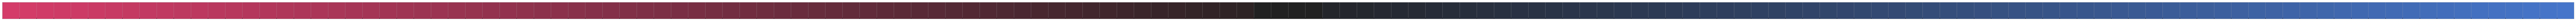

In [3]:
#defining color palette
sns.palplot(sns.diverging_palette(0, 255, sep=8, n=150, center='dark'))

main_facecolor = '#FFFFFF'
main_facecolor2 = '#0D0D0D'
cmap1 = sns.diverging_palette(230, 20, as_cmap=True)
cmap2 = ["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333", "#3c4e4b", "#466964", "#599e94", "#6cd4c5"]
cmap3 = sns.diverging_palette(0, 255, sep=1, n=50, center='dark')

In [4]:
def plot_heatmap(data, title, figsize=(16, 10)):
    mask = np.triu(np.ones_like(data, dtype=bool))
    fig, ax = plt.subplots(figsize=figsize, facecolor=main_facecolor)
    ax.set_facecolor('#f0f0f0')
    ax.grid(False)
    ax.set_title(title, fontsize=14, fontweight='semibold', fontfamily='sans-serif', color="#413f42",
                 bbox=dict(facecolor='#f0f0f0', edgecolor='#d5d3d6', boxstyle='round,pad=0.6', alpha=0.6))

    _ = sns.heatmap(data, cmap=cmap3, vmax=1, vmin=-1, center=0, square=True, annot=True, linewidths=.5,
                    linecolor='#f0f0f0', cbar_kws={"shrink": .5}, annot_kws={"size": 8}, fmt=".2f")


In [5]:
def is_binary(series, unique_tol=2):
    return series.nunique() <= unique_tol

def mixed_corr(df):
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    
    for col1 in df.columns:
        for col2 in df.columns:
            try:
                if is_binary(df[col1]) and is_binary(df[col2]):
                    # Both are binary
                    corr_val = df[col1].corr(df[col2], method='pearson')
                elif is_binary(df[col1]) or is_binary(df[col2]):
                    # One is binary and the other is continuous
                    binary_col = col1 if is_binary(df[col1]) else col2
                    cont_col = col2 if is_binary(df[col1]) else col1
                    corr_val = pointbiserialr(df[cont_col], df[binary_col])[0]
                else:
                    # Both are continuous
                    corr_val = df[col1].corr(df[col2])
                
                corr_matrix.at[col1, col2] = corr_val
            except Exception as e:
                print(f"An error occurred while processing {col1} and {col2}: {e}")
    return corr_matrix

def enforce_symmetry(df):
    return (df + df.T)/2

df_numeric = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])
mixed_corr_matrix = mixed_corr(df_numeric)

dissimilarity = 1 - abs(mixed_corr_matrix)

# Enforce symmetry
symmetric_dissimilarity = enforce_symmetry(dissimilarity)

# Set diagonal to zero
np.fill_diagonal(symmetric_dissimilarity.values, 0)

# Check for symmetry
print((symmetric_dissimilarity.T == symmetric_dissimilarity).all().all())

# Proceed with clustering
Z = linkage(squareform(symmetric_dissimilarity), 'ward')

True


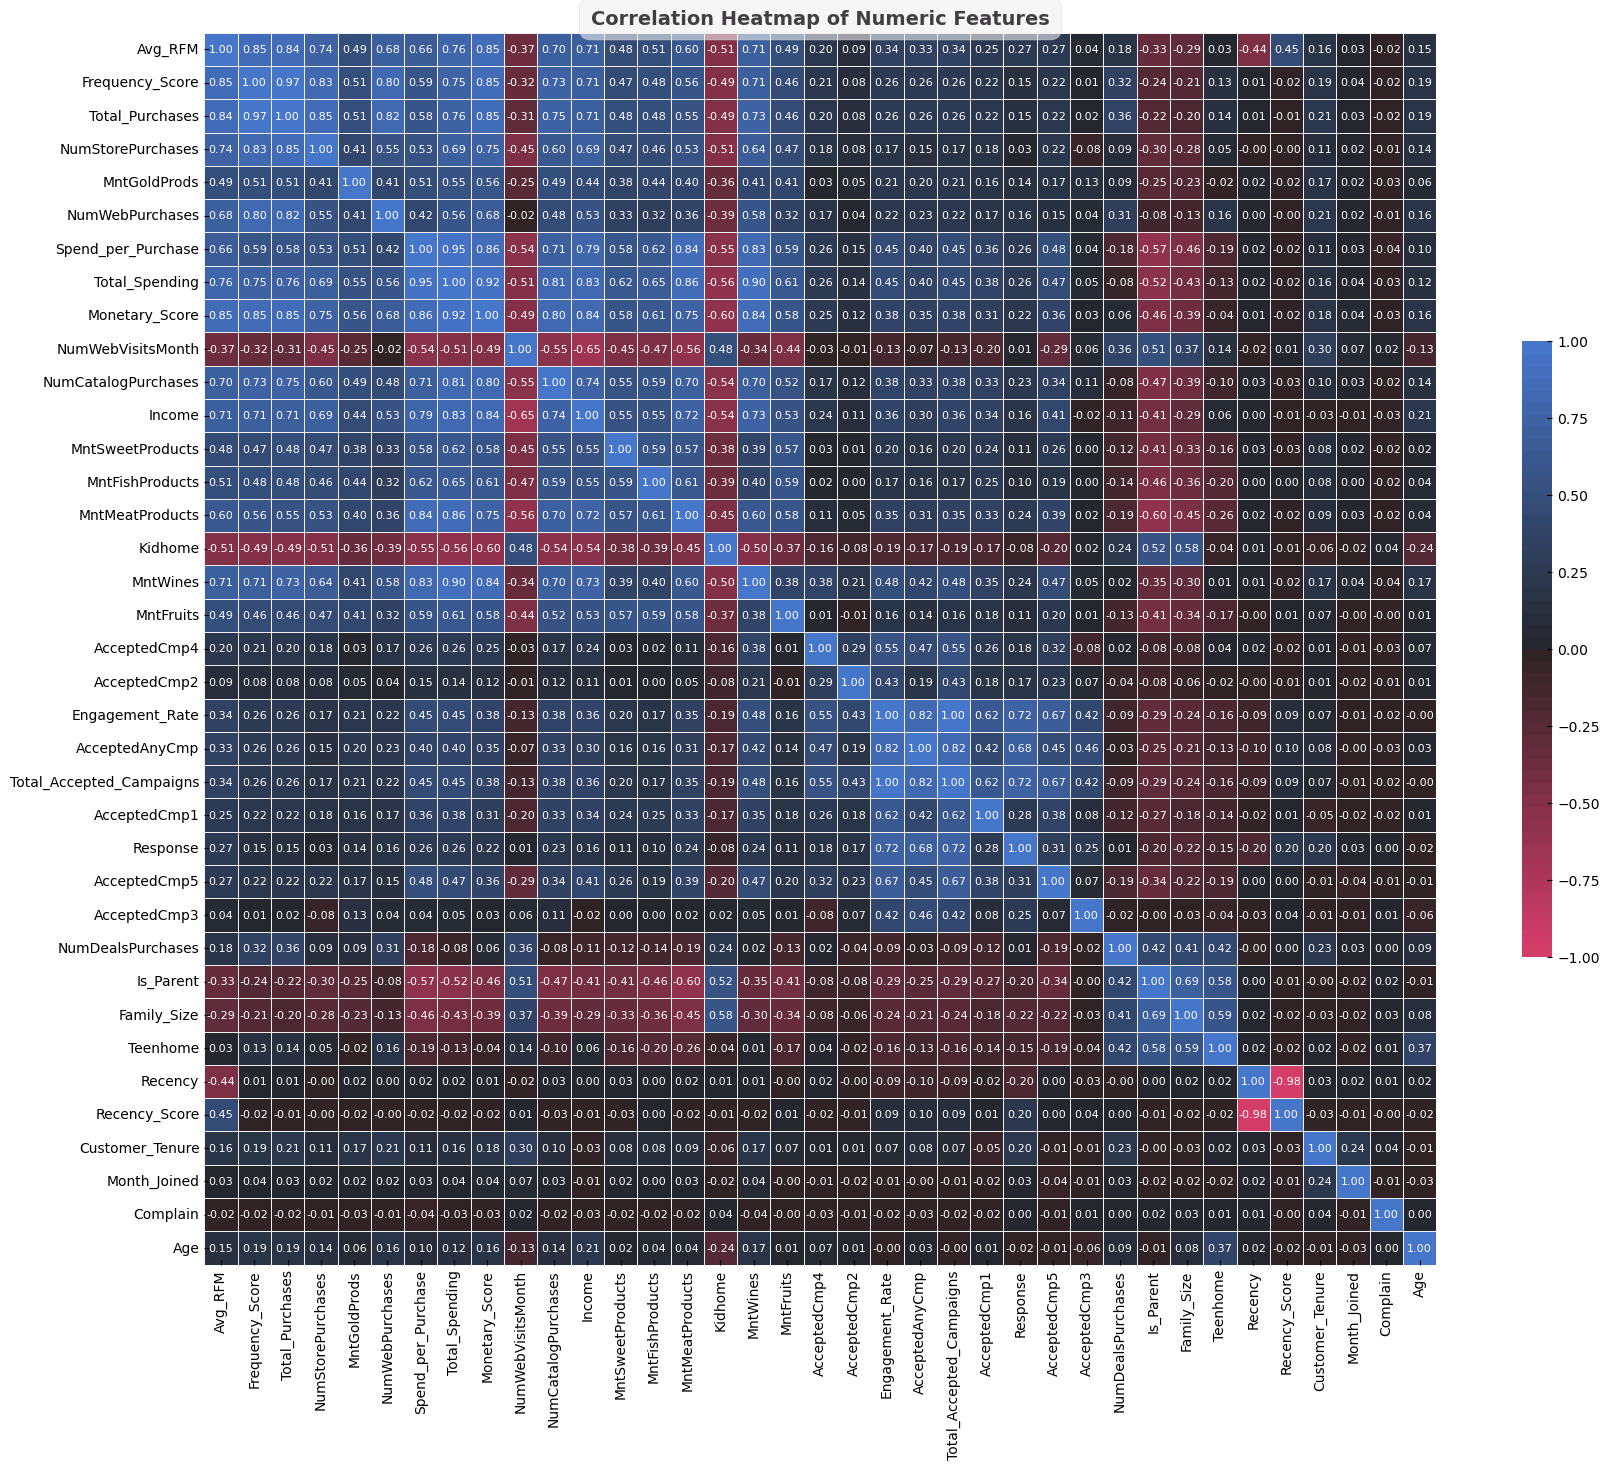

In [6]:
# Clusterize the data
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(df_numeric.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df_numeric[i])
    else:
        df_to_append = pd.DataFrame(df_numeric[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

clustered_corr = clustered.corr()

#create correlation heat map of numeric features
mask = np.triu(np.ones_like(clustered_corr, dtype=bool))
fig, ax = plt.subplots(figsize=(22, 16), facecolor=main_facecolor)
ax.set_facecolor('#f0f0f0')
ax.grid(False)
ax.set_title('Correlation Heatmap of Numeric Features', fontsize=14, fontweight='semibold', fontfamily='sans-serif', color="#413f42",
             bbox=dict(facecolor='#f0f0f0', edgecolor='#d5d3d6', boxstyle='round,pad=0.6', alpha=0.6))

_ = sns.heatmap(clustered_corr, cmap=cmap3, vmax=1, vmin=-1, center=0, square=True, annot=True, linewidths=.5, linecolor='#f0f0f0', 
            cbar_kws={"shrink": .5}, annot_kws={"size": 8}, fmt=".2f")

In [7]:
#create is_widow
df['is_widow'] = df['Marital_Status'].apply(lambda x: 1 if x == 'Widow' else 0)

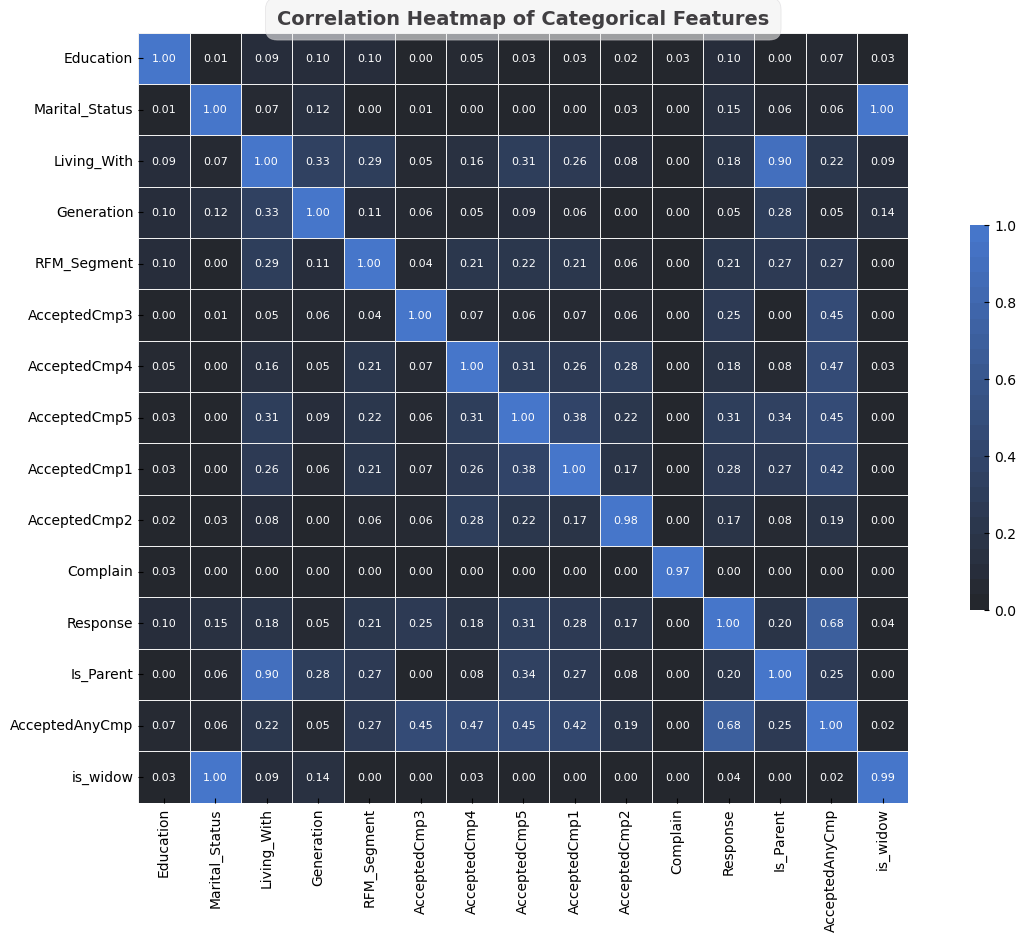

In [8]:
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorial-categorial association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def chi2_and_cramers_v(df, target, variables):
    results = []
    for var in variables:
        contingency_table = pd.crosstab(df[target], df[var])
        chi2, p, _, _ = stats.chi2_contingency(contingency_table)
        v = cramers_v(df[var], df[target])
        results.append([var, chi2, p, v])

    results_df = pd.DataFrame(results, columns=['Variable', 'Chi-square statistic', 'P-value', 'Cramers_V'])
    results_df = results_df.sort_values(by='Cramers_V', ascending=False)
    return results_df

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
df_cat_bin = df[cat_cols + binary_cols]

# Build the association matrix
cat_assoc_matrix = pd.DataFrame(index=df_cat_bin.columns, columns=df_cat_bin.columns)
for col1 in df_cat_bin.columns:
    for col2 in df_cat_bin.columns:
        cat_assoc_matrix.at[col1, col2] = cramers_v(df_cat_bin[col1], df_cat_bin[col2])

#plot heatmap
fig, ax = plt.subplots(figsize=(16, 10), facecolor=main_facecolor)
ax.set_facecolor('#f0f0f0')
ax.grid(False)
ax.set_title('Correlation Heatmap of Categorical Features', fontsize=14, fontweight='semibold', fontfamily='sans-serif', color="#413f42",
                bbox=dict(facecolor='#f0f0f0', edgecolor='#d5d3d6', boxstyle='round,pad=0.6', alpha=0.6))

_ = sns.heatmap(cat_assoc_matrix.astype(float), cmap=cmap3, vmax=1, vmin=0, center=0, square=True, annot=True, linewidths=.5, linecolor='#f0f0f0',
            cbar_kws={"shrink": .5}, annot_kws={"size": 8}, fmt=".2f")


In [10]:
# Find where the absolute correlations are above a certain threshold (e.g., greater than 0.7)
high_assoc_var = np.where(cat_assoc_matrix > 0.35)

# Get the indices for highly correlated variables
high_assoc_var_indices = np.unique(np.concatenate(high_assoc_var))

# Get the variable names for highly correlated variables
high_assoc_var_pairs = [(cat_assoc_matrix.index[x], cat_assoc_matrix.columns[y]) for x, y in zip(*high_assoc_var) if x != y]


high_assoc_var_pairs

[('Marital_Status', 'is_widow'),
 ('Living_With', 'Is_Parent'),
 ('AcceptedCmp3', 'AcceptedAnyCmp'),
 ('AcceptedCmp4', 'AcceptedAnyCmp'),
 ('AcceptedCmp5', 'AcceptedCmp1'),
 ('AcceptedCmp5', 'AcceptedAnyCmp'),
 ('AcceptedCmp1', 'AcceptedCmp5'),
 ('AcceptedCmp1', 'AcceptedAnyCmp'),
 ('Response', 'AcceptedAnyCmp'),
 ('Is_Parent', 'Living_With'),
 ('AcceptedAnyCmp', 'AcceptedCmp3'),
 ('AcceptedAnyCmp', 'AcceptedCmp4'),
 ('AcceptedAnyCmp', 'AcceptedCmp5'),
 ('AcceptedAnyCmp', 'AcceptedCmp1'),
 ('AcceptedAnyCmp', 'Response'),
 ('is_widow', 'Marital_Status')]

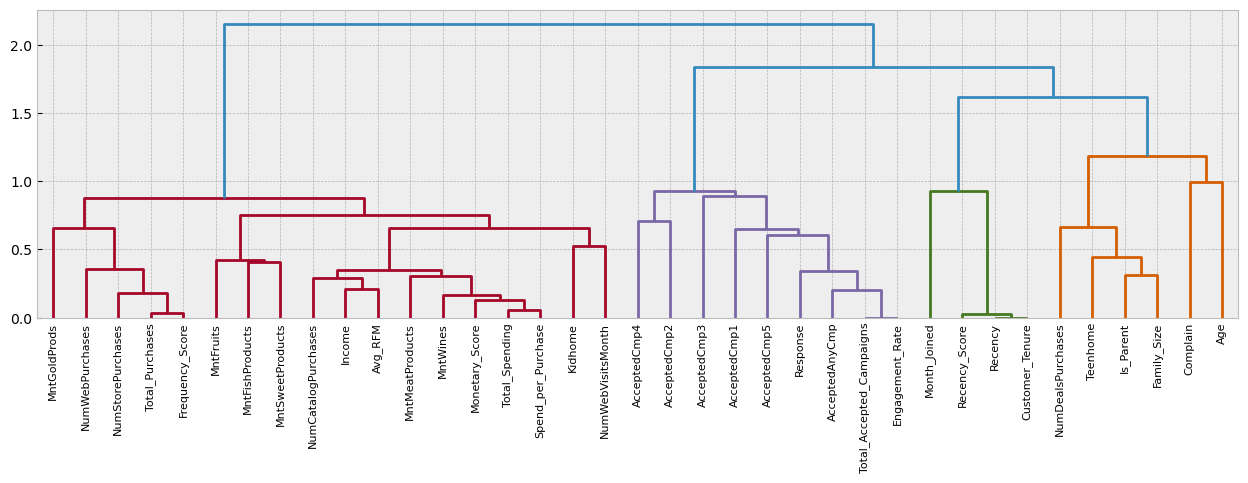

In [11]:
plt.figure(figsize=(15.5,4))

_ = dendrogram(Z, labels=df_numeric.columns, orientation='top', 
           leaf_rotation=90)



In this project, I selected the following features for clustering:

Categorical features:
- RFM_Segment: This feature indicates the customer's RFM segment, which is a measure of their purchase behavior.
- Generation: This feature indicates the customer's generation.
- Income_Category: This feature indicates the customer's income category.

Binary features:
- Response: This feature indicates whether or not the customer has responded to a marketing campaign in the past.
- Is_Parent: This feature indicates whether or not the customer is a parent.
- is_widow: This feature indicates whether or not the customer is a widow.

Numerical features:
- Recency_Score: This feature indicates how recently the customer has made a purchase.
- Age: This feature indicates the customer's age.
- Engagement_Rate: This feature indicates how often the customer engages with the company's marketing campaigns.
- Customer_Tenure: This feature indicates how long the customer has been a customer of the company.
- Spend_per_Purchase: This feature indicates how much money the customer spends per purchase.

These features were chosen because they are relevant to the clustering objective, which is to identify groups of customers with similar characteristics. They are also measurable and can be easily quantified. Additionally, they are not correlated with each other, which will help to ensure that the clustering algorithm is able to find distinct clusters.

The features were also chosen to be representative of the different customer characteristics and behaviors. This will allow me to identify different segments of customers and develop more targeted marketing campaigns.

In [9]:
df['Income_Category'] = pd.qcut(df['Income'], q=6, labels=None)

#replace customer_tenure == 0 to 1
df['Customer_Tenure'] = df['Customer_Tenure'].replace(0, 1)


#create engagement_rate from response and accemptedcmp1 until accemptedcmp5
df['Engagement_Rate'] = df[['Response', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)/6


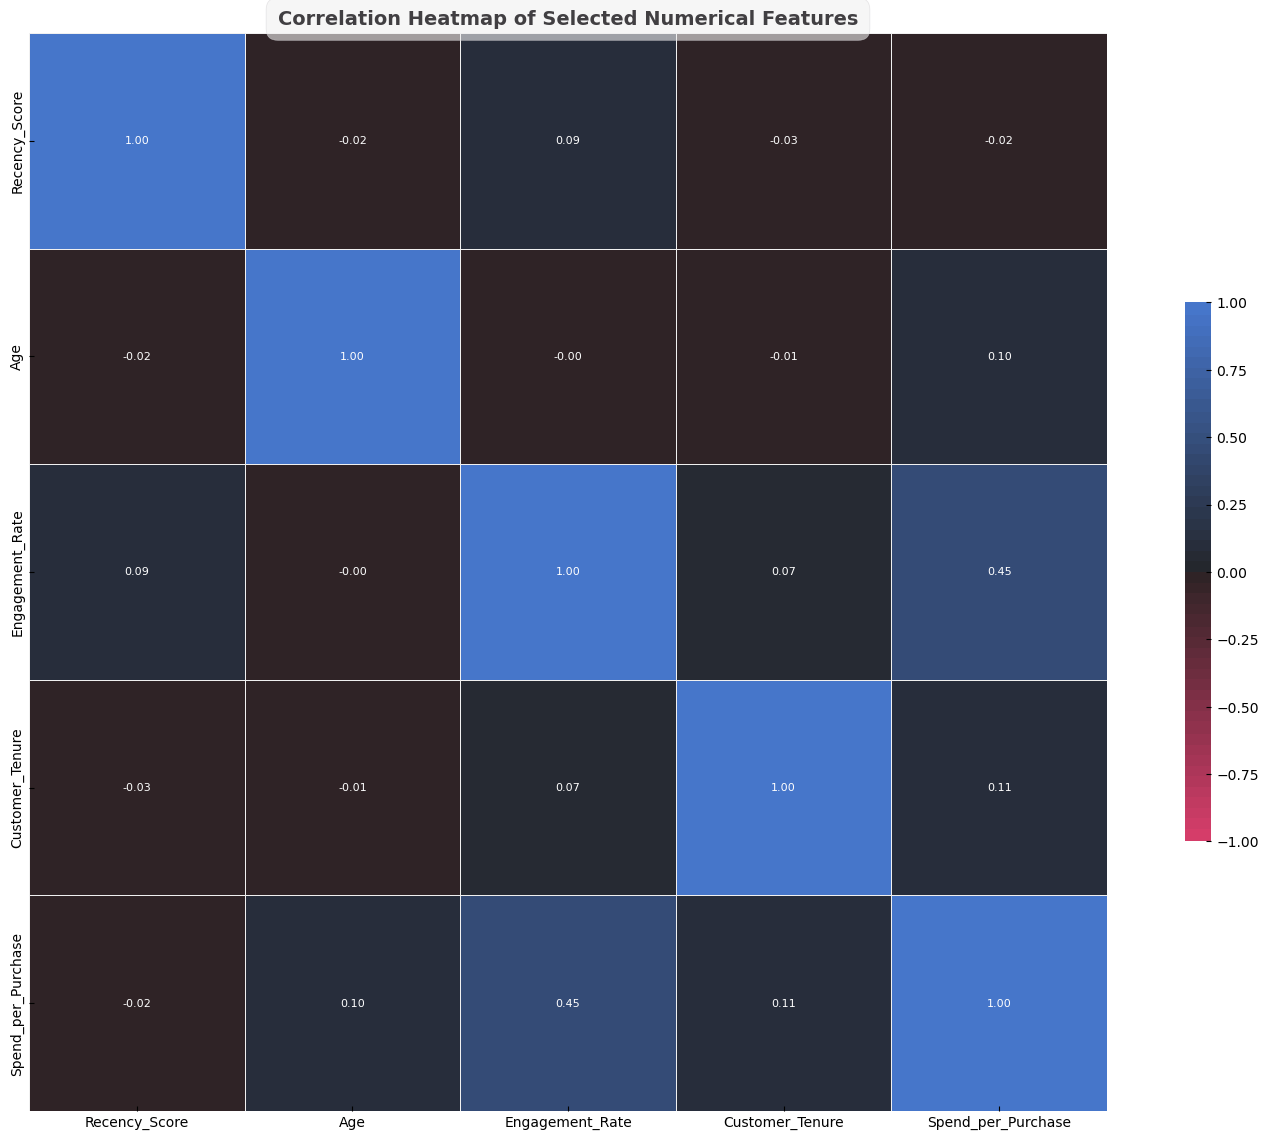

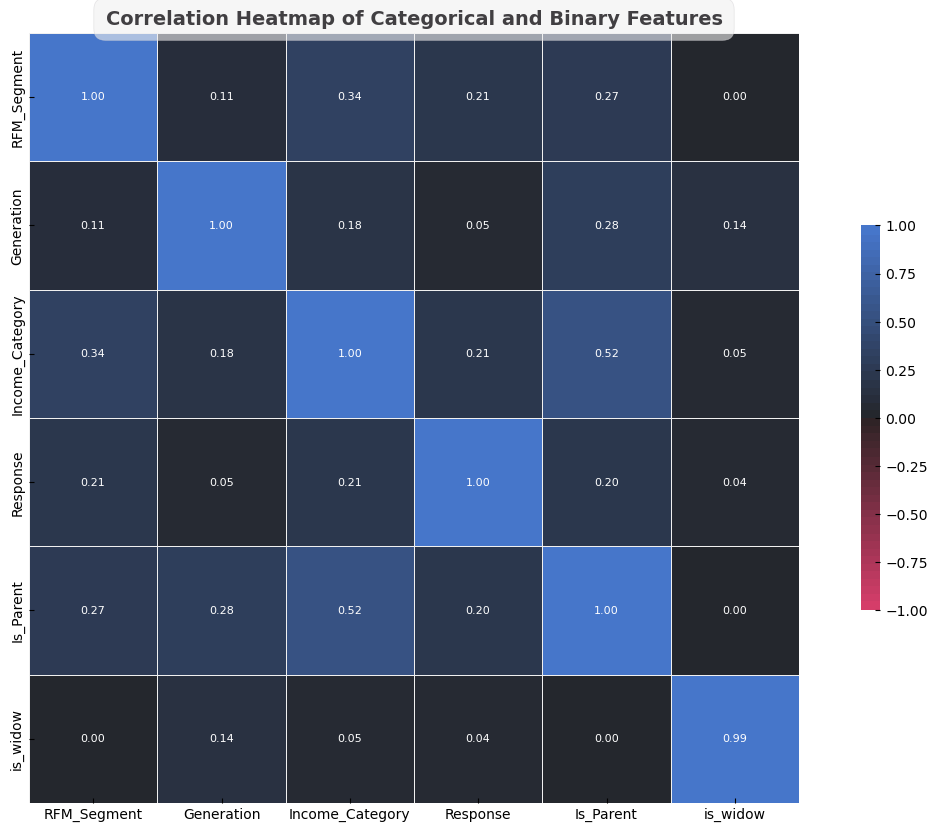

In [63]:
selected_catvars = ['RFM_Segment', 'Generation', 'Income_Category']
selected_binvars = ['Response', 'Is_Parent', 'is_widow']
selected_numvars = ['Recency_Score',  'Age',  'Engagement_Rate', 'Customer_Tenure', 'Spend_per_Purchase']

df_filtered = df[selected_catvars + selected_numvars + selected_binvars]
df_filtered[selected_binvars] = df_filtered[selected_binvars].astype(bool)

# Plot correlation matrix for selected numerical variables
corr_numvars = df_filtered[selected_numvars].corr()
plot_heatmap(corr_numvars, 'Correlation Heatmap of Selected Numerical Features', figsize=(20, 14))

df_cat_bin = df[selected_catvars + selected_binvars]
# Build the association matrix for categorical and binary variables
cat_assoc_matrix = pd.DataFrame(index=df_cat_bin.columns, columns=df_cat_bin.columns)
for col1 in df_cat_bin.columns:
    for col2 in df_cat_bin.columns:
        cat_assoc_matrix.at[col1, col2] = cramers_v(df_cat_bin[col1], df_cat_bin[col2])

# Plot heatmap for categorical and binary variables
plot_heatmap(cat_assoc_matrix.astype(float), 'Correlation Heatmap of Categorical and Binary Features')

In [10]:
def fit_and_evaluate(df_filtered, cluster_selection_method='leaf', umap_combine_method='intersection_union_mapper', n_neighbors=20, 
                    min_cluster_size=100, min_samples=15, colormap="tab10"):
    from matplotlib.colors import ListedColormap
    clf = DenseClus(
        random_state=42,
        cluster_selection_method=cluster_selection_method,
        umap_combine_method=umap_combine_method,
        n_neighbors=n_neighbors,
        min_cluster_size=min_cluster_size, 
        min_samples=min_samples
    )

    # Fit the model
    clf.fit(df_filtered)
    
    # Get labels and summarize
    labels = clf.score()  
    cluster_summary = pd.DataFrame(labels).value_counts(normalize=True).reset_index()
    cluster_summary.columns = ['Cluster', 'Proportion']
    cluster_summary = cluster_summary.sort_values(by='Cluster')

    # Coverage and DBCV Score
    embedding = clf.mapper_.embedding_
    coverage = np.sum(labels != -1) / embedding.shape[0]  # -1 labels are noise
    dbcv_score = clf.hdbscan_.relative_validity_
    
    # Prepare color map
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    sns_palette = sns.color_palette(colormap, n_clusters)
    cmap = ListedColormap(sns_palette)
    
    # Create a Matplotlib figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    title_text = f"Coverage: {coverage:.2f}, DBCV Score: {dbcv_score:.2f}"
    fig.suptitle(title_text, fontsize=14, fontweight='light')
    
    # First Plot: condensed_tree
    clf.hdbscan_.condensed_tree_.plot(
        axis=axes[1],
        select_clusters=True,
        label_clusters=False,
        colorbar=True,
        selection_palette=sns_palette,
    )
    
    # Second Plot: KDE jointplot mimic
    sns.kdeplot(
        x=clf.mapper_.embedding_[:, 0],
        y=clf.mapper_.embedding_[:, 1],
        hue=labels,
        palette=sns_palette,
        fill=True,
        ax=axes[0]
    )
    
    axes[0].scatter(
        clf.mapper_.embedding_[:, 0],
        clf.mapper_.embedding_[:, 1],
        c=labels,
        cmap=cmap,
        s=50,
        alpha=0.6,
        edgecolors='w'
    )
    
    plt.tight_layout()
    plt.show()

    display(cluster_summary)

    return embedding, labels
    
def plot_trustworthiness(df, method='eom', K=30):
    clf = DenseClus(
        random_state=42,
        cluster_selection_method=method,
        umap_combine_method="intersection_union_mapper",
    )
    clf.fit(df)

    numerical_trustworthiness = validation.trustworthiness_vector(source=clf.numerical_umap_._raw_data
                                  ,embedding=clf.numerical_umap_.embedding_
                                  ,max_k=K)

    categorical_trustworthiness = validation.trustworthiness_vector(source=clf.categorical_umap_._raw_data
                                  ,embedding=clf.categorical_umap_.embedding_
                                  ,max_k=K)

    plt.figure(figsize=(8, 6))
    plt.plot(numerical_trustworthiness)
    plt.plot(categorical_trustworthiness)
    plt.xlabel("Value of K")
    plt.ylabel("Trustworthiness score")
    plt.title(f"Trustworthiness at {K}")
    plt.legend(["Numerical T", "Categorical T"], loc="upper right")
    plt.show()



def plot_dbcv_scores(df, method='eom', k_min=10, k_max=20):
    # Get dbcv score over k values
    dbcv_scores = []
    k_values = range(k_min, k_max)

    for k in k_values:
        clf = DenseClus(
            random_state=42,
            cluster_selection_method=method,
            umap_combine_method="intersection_union_mapper",
            n_neighbors=k,
        )

        clf.fit(df)
        dbcv_scores.append(clf.hdbscan_.relative_validity_)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, dbcv_scores, marker='o', linestyle='-', color='b')
    plt.xlabel("Value of K")
    plt.ylabel("DBCV score")
    plt.title("DBCV score vs. Value of K")
    plt.grid(True)
    plt.xticks(k_values)
    plt.show()

c:\Users\ramdh\anaconda3\envs\clustering_env\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
c:\Users\ramdh\anaconda3\envs\clustering_env\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\ramdh\anaconda3\envs\clustering_env\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
c:\Users\ramdh\anaconda3\envs\clustering_env\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
c:\Users\ramdh\anaconda3\envs\clustering_env\lib\site-packa

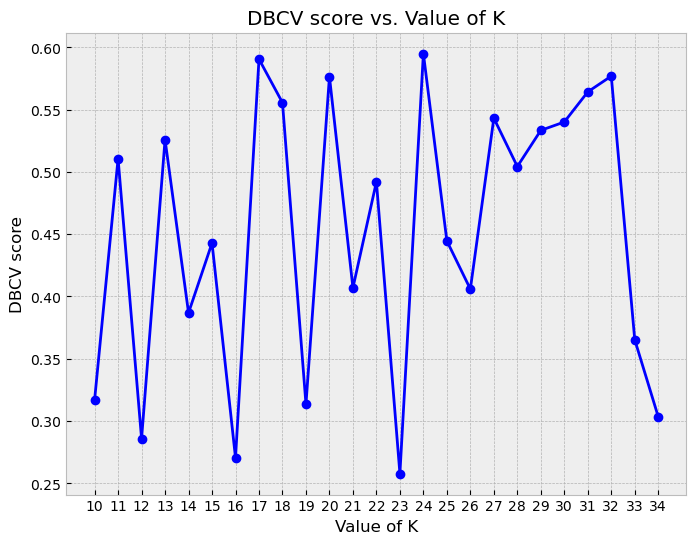

In [61]:
selected_catvars = ['RFM_Segment', 'Generation', 'Income_Category']
selected_binvars = ['Response', 'Is_Parent', 'is_widow']
selected_numvars = ['Recency_Score',  'Age',  'Engagement_Rate', 'Customer_Tenure', 'Spend_per_Purchase']


clustering_input_data = df[selected_catvars + selected_numvars + selected_binvars]
clustering_input_data[selected_binvars] = clustering_input_data[selected_binvars].astype(bool)


plot_dbcv_scores(clustering_input_data, 'eom', 10, 35)

c:\Users\ramdh\anaconda3\envs\clustering_env\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


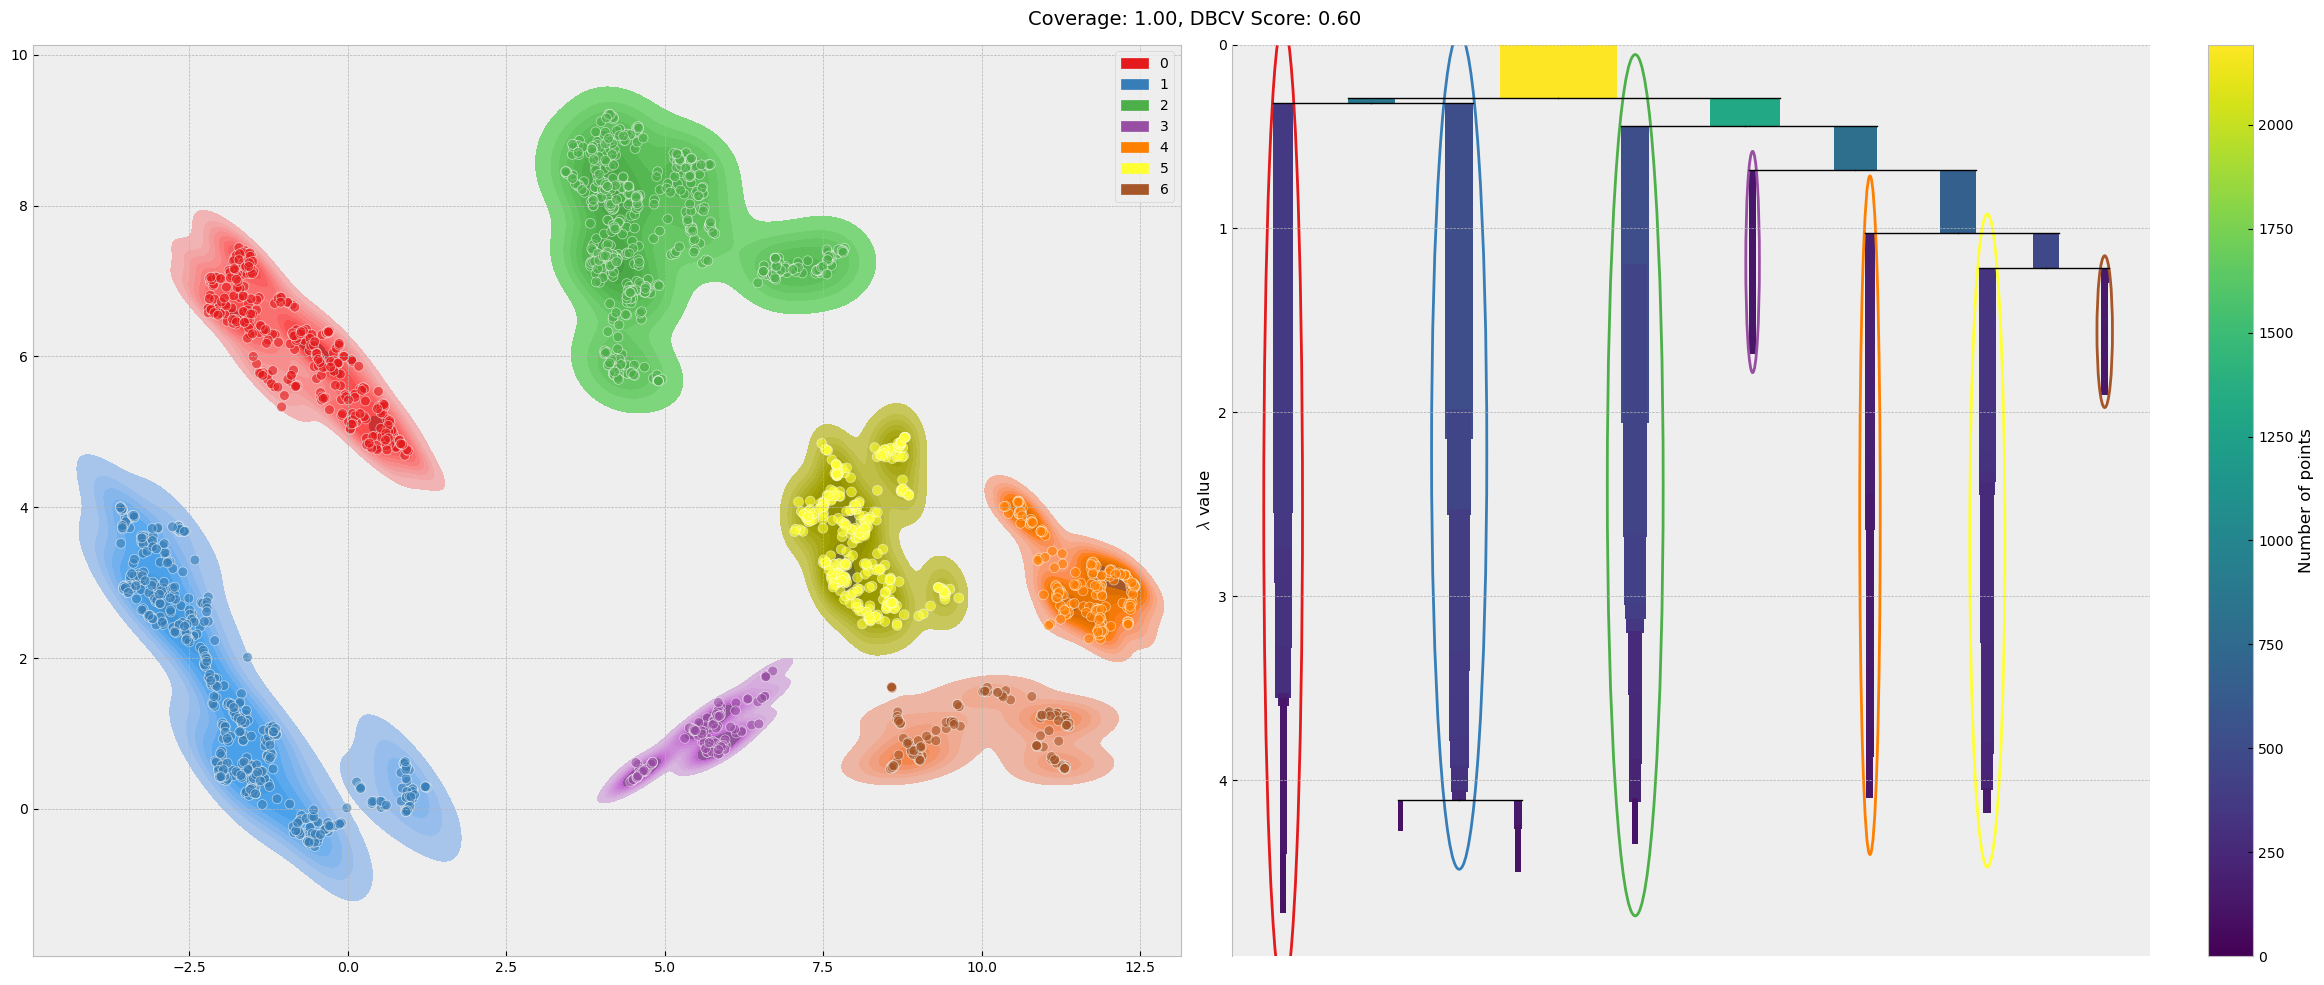

,Cluster,Proportion
2,0,0.165071
1,1,0.235294
0,2,0.238030
6,3,0.057912
4,4,0.087551
3,5,0.150023
5,6,0.066119


,Recency_Score,Frequency_Score,Monetary_Score,Avg_RFM,Age,Income,Is_Parent,Generation,RFM_Segment,Living_With,Marital_Status,Education
Umap_Cluster,,,,,,,,,,,,
0,1.0,3.0,3.0,3.000000,65.0,56129.0,1,Baby_Boomers,Can't Lose,With_Teens,Married,Bachelor's Degree
1,2.0,3.0,3.0,2.333333,47.0,46098.0,1,Generation_X,Can't Lose,With_Kids,Married,Bachelor's Degree
2,4.0,3.0,3.0,3.666667,66.0,57519.0,1,Baby_Boomers,Champions,With_Teens,Married,Bachelor's Degree
3,3.0,1.0,1.0,2.000000,46.0,29187.0,1,Generation_X,Promising,With_Kids,Married,Bachelor's Degree
4,5.0,2.0,2.0,2.666667,50.0,32754.5,1,Generation_X,New,With_Kids,Married,Bachelor's Degree
5,4.0,4.0,4.0,4.000000,49.0,62882.0,1,Generation_X,Champions,With_Teens,Married,Bachelor's Degree
6,4.0,3.0,3.0,3.333333,36.0,41411.0,0,Millennials,Champions,Alone,Married,Bachelor's Degree


In [55]:
selected_catvars = ['RFM_Segment', 'Generation', 'Income_Category']
selected_binvars = ['Response', 'Is_Parent', 'is_widow']
selected_numvars = ['Recency_Score',  'Age',  'Engagement_Rate', 'Customer_Tenure', 'Spend_per_Purchase']

df_filtered2 = df[selected_catvars + selected_numvars + selected_binvars]
df_filtered2[selected_binvars] = df_filtered2[selected_binvars].astype(bool)

# Fit and evaluate
umap_embedding, labels = fit_and_evaluate(df_filtered2, 'eom', 'intersection_union_mapper', n_neighbors=24, colormap='Set1')

df['Umap_Cluster'] = labels
cluster_profiles = df.groupby('Umap_Cluster').agg({
        'Recency_Score': 'median',
        'Frequency_Score': 'median',
        'Monetary_Score': 'median',
        'Avg_RFM': 'median',
        'Age': 'median',
        'Income': 'median',
        'Is_Parent': lambda x: x.value_counts().index[0],
        'Generation': lambda x: x.value_counts().index[0],
        'RFM_Segment': lambda x: x.value_counts().index[0:1],
        'Living_With': lambda x: x.value_counts().index[0],
        'Marital_Status': lambda x: x.value_counts().index[0],
        'Education': lambda x: x.value_counts().index[0]
    }).reset_index()

cluster_profiles.set_index('Umap_Cluster')

c:\Users\ramdh\anaconda3\envs\clustering_env\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


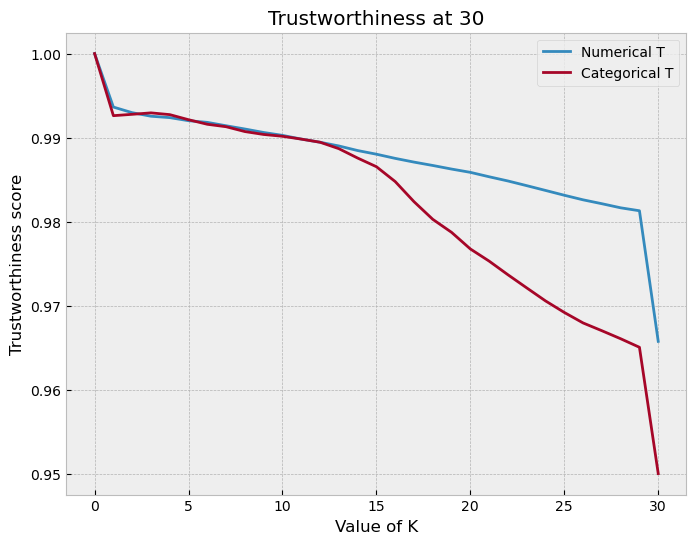

In [62]:
plot_trustworthiness(df_filtered2,method='eom', K=30)

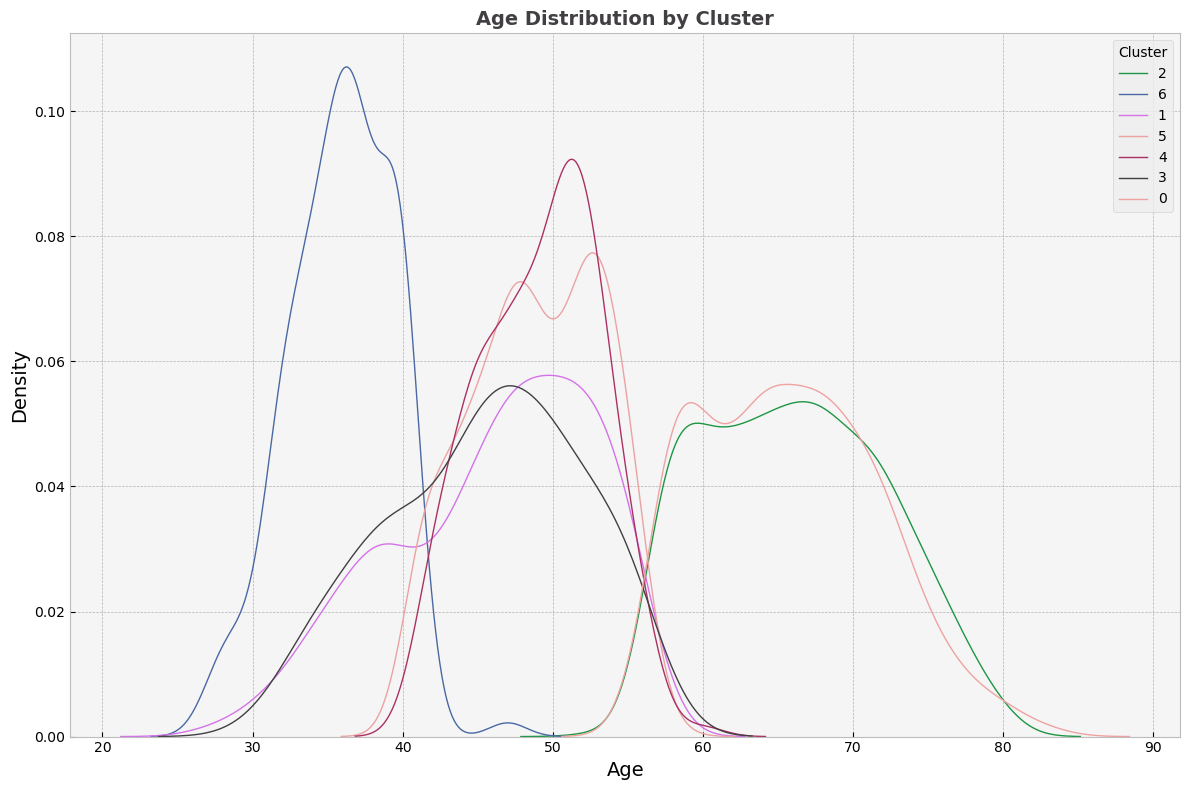

In [57]:
df['Umap_Cluster'] = labels

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Age Distribution by Cluster', fontsize=14, fontweight='semibold', color="#413f42")
ax.set_facecolor('#f5f5f5')
# clusters = [0, 1, 2, 3, 4, 5]
clusters = df[df['Umap_Cluster']!=-1]['Umap_Cluster'].unique()
colors = ['#1d9643', '#4a68a3', '#d472e8', '#eba2a2', '#ab3063', '#413f42', '#efa2a2', '#3ba2a2']

for segment, color in zip(clusters, colors):
    sns.kdeplot(data=df[df['Umap_Cluster'] == segment]['Age'], color=color, ax=ax, label=segment, linewidth=1)

ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend(loc='upper right', title='Cluster')
plt.tight_layout()
plt.show()
                

## Hyperparameter Tuning

In [64]:
import hdbscan
import optuna
import numpy as np
from sklearn.metrics import pairwise_distances
from hyperopt import hp

def tune_hdbscan(umap_embedding, n_trials=100, min_cluster_start=0.01, min_cluster_end=0.15,
                 min_samples_start=0.01, min_samples_end=0.15, max_epsilon=None):
    n_rows = umap_embedding.shape[0]

    # Define the search space
    space = {
        'min_cluster_size': hp.quniform('min_cluster_size', int(n_rows * min_cluster_start),
                                         int(n_rows * min_cluster_end), 1),
        'min_samples': hp.quniform('min_samples', int(n_rows * min_samples_start),
                                   int(n_rows * min_samples_end), 1),
        'cluster_selection_method': hp.choice('cluster_selection_method', ['eom']),
        'metric': hp.choice('metric', ['euclidean', 'manhattan'])
    }

    def objective(trial):
        # Use trial.suggest_int to sample values from the defined search space
        min_cluster_number = trial.suggest_int("min_cluster_size", 10, 100, 5)
        min_samples_number = trial.suggest_int("min_samples", 1, 25, 1)
        
        #select metric from space
        metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])

        if max_epsilon is not None:
            cluster_selection_epsilon_number = trial.suggest_float("cluster_selection_epsilon", 0, max_epsilon)
            hdb_model = hdbscan.HDBSCAN(metric=metric, min_cluster_size=min_cluster_number,
                    min_samples=min_samples_number,
                    cluster_selection_epsilon=cluster_selection_epsilon_number,
                    gen_min_span_tree=True).fit(umap_embedding)
        else:
            hdb_model = hdbscan.HDBSCAN(metric=metric, min_cluster_size=min_cluster_number,
                    min_samples=min_samples_number,
                    gen_min_span_tree=True).fit(umap_embedding)

        score = hdb_model.relative_validity_

        return score


    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    best_model_params = study.best_params

    print("Best parameters: ", best_model_params)

    if max_epsilon is not None:
        hdb_model = hdbscan.HDBSCAN(min_cluster_size=best_model_params['min_cluster_size'],
                                    min_samples=best_model_params['min_samples'],
                                    cluster_selection_epsilon=best_model_params['cluster_selection_epsilon'],
                                    gen_min_span_tree=True).fit(umap_embedding)
    else:
        hdb_model = hdbscan.HDBSCAN(min_cluster_size=best_model_params['min_cluster_size'],
                                    min_samples=best_model_params['min_samples'],
                                    gen_min_span_tree=True).fit(umap_embedding)

    return hdb_model

tuned_hdb_model = tune_hdbscan(umap_embedding, n_trials=300, min_cluster_start=0.01, min_cluster_end=0.15,
                                min_samples_start=0.01, min_samples_end=0.15, max_epsilon=None)


[I 2023-09-13 18:34:11,588] A new study created in memory with name: no-name-0a8ef4e5-ac88-4b2f-97b2-c0ce1b2e85a8
[I 2023-09-13 18:34:11,672] Trial 0 finished with value: 0.3815996995409315 and parameters: {'min_cluster_size': 40, 'min_samples': 7, 'metric': 'manhattan'}. Best is trial 0 with value: 0.3815996995409315.
[I 2023-09-13 18:34:11,744] Trial 1 finished with value: 0.5453659696741098 and parameters: {'min_cluster_size': 80, 'min_samples': 13, 'metric': 'manhattan'}. Best is trial 1 with value: 0.5453659696741098.
[I 2023-09-13 18:34:11,819] Trial 2 finished with value: 0.6797226062845725 and parameters: {'min_cluster_size': 50, 'min_samples': 3, 'metric': 'euclidean'}. Best is trial 2 with value: 0.6797226062845725.
[I 2023-09-13 18:34:11,897] Trial 3 finished with value: 0.703659535276179 and parameters: {'min_cluster_size': 85, 'min_samples': 3, 'metric': 'euclidean'}. Best is trial 3 with value: 0.703659535276179.
[I 2023-09-13 18:34:11,973] Trial 4 finished with value: 0.

Best parameters:  {'min_cluster_size': 75, 'min_samples': 1, 'metric': 'euclidean'}


c:\Users\ramdh\anaconda3\envs\clustering_env\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


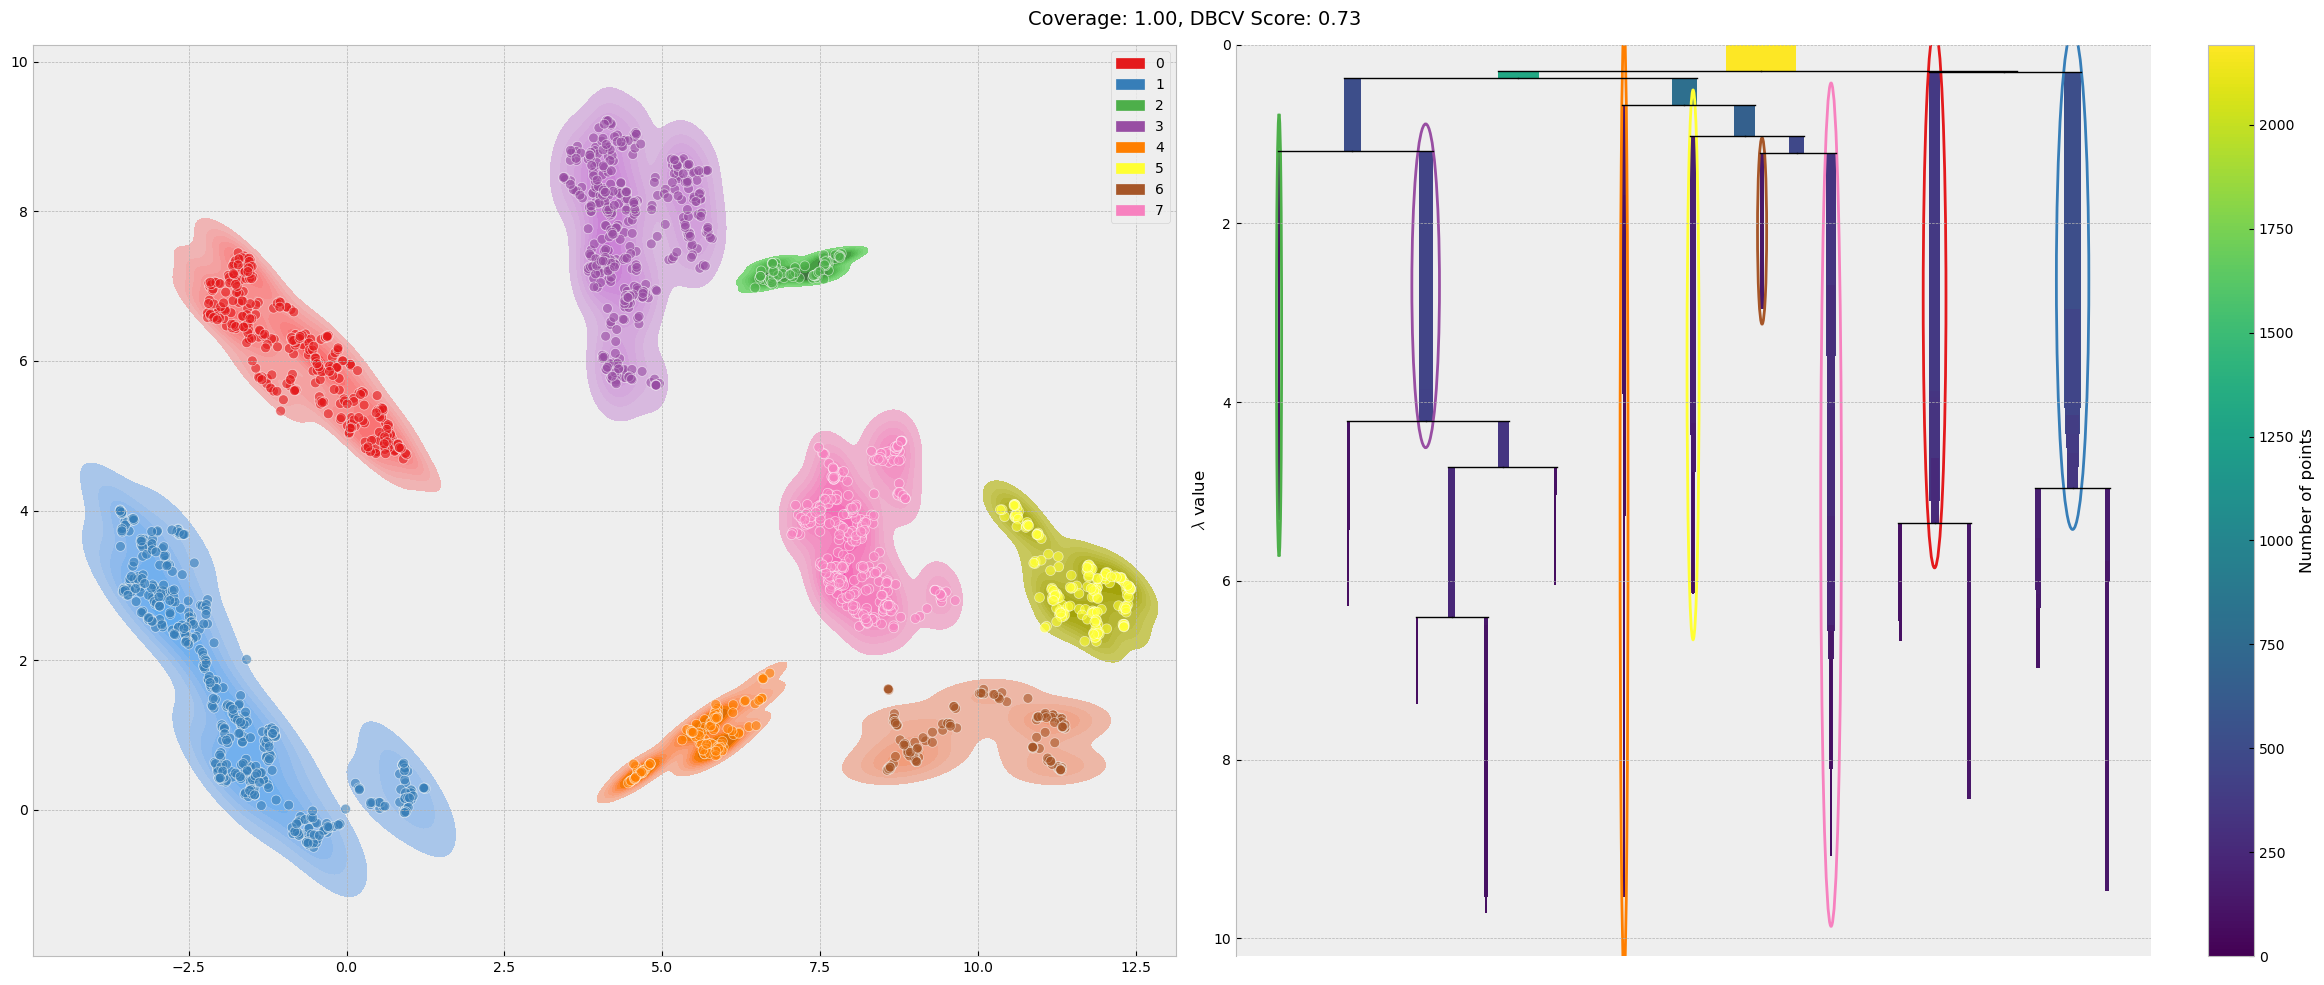

,Cluster,Proportion
2,0,0.165071
0,1,0.235294
7,2,0.037848
1,3,0.200182
6,4,0.057912
4,5,0.087551
5,6,0.066119
3,7,0.150023


,Recency_Score,Frequency_Score,Monetary_Score,Avg_RFM,Age,Income,Is_Parent,Generation,RFM_Segment
Umap_Cluster,,,,,,,,,
0,1.0,3.0,3.0,3.000000,65.0,56129.0,1,Baby_Boomers,Can't Lose
1,2.0,3.0,3.0,2.333333,47.0,46098.0,1,Generation_X,Can't Lose
2,4.0,1.0,1.0,2.333333,64.0,36443.0,1,Baby_Boomers,New
3,4.0,4.0,4.0,4.000000,66.0,62000.0,1,Baby_Boomers,Champions
4,3.0,1.0,1.0,2.000000,46.0,29187.0,1,Generation_X,Promising
5,5.0,2.0,2.0,2.666667,50.0,32754.5,1,Generation_X,New
6,4.0,3.0,3.0,3.333333,36.0,41411.0,0,Millennials,Champions
7,4.0,4.0,4.0,4.000000,49.0,62882.0,1,Generation_X,Champions


In [59]:
# Fit and evaluate
umap_embedding_opt, labels_opt = fit_and_evaluate(df_filtered2, 'eom', 'intersection_union_mapper', n_neighbors=24, 
                                                min_cluster_size= 75, min_samples=1, colormap='Set1')

df['Umap_Cluster'] = labels_opt
cluster_profiles = df.groupby('Umap_Cluster').agg({
        'Recency_Score': 'median',
        'Frequency_Score': 'median',
        'Monetary_Score': 'median',
        'Avg_RFM': 'median',
        'Age': 'median',
        'Income': 'median',
        'Is_Parent': lambda x: x.value_counts().index[0],
        'Generation': lambda x: x.value_counts().index[0],
        'RFM_Segment': lambda x: x.value_counts().index[0:1],
    }).reset_index()

cluster_profiles.set_index('Umap_Cluster')

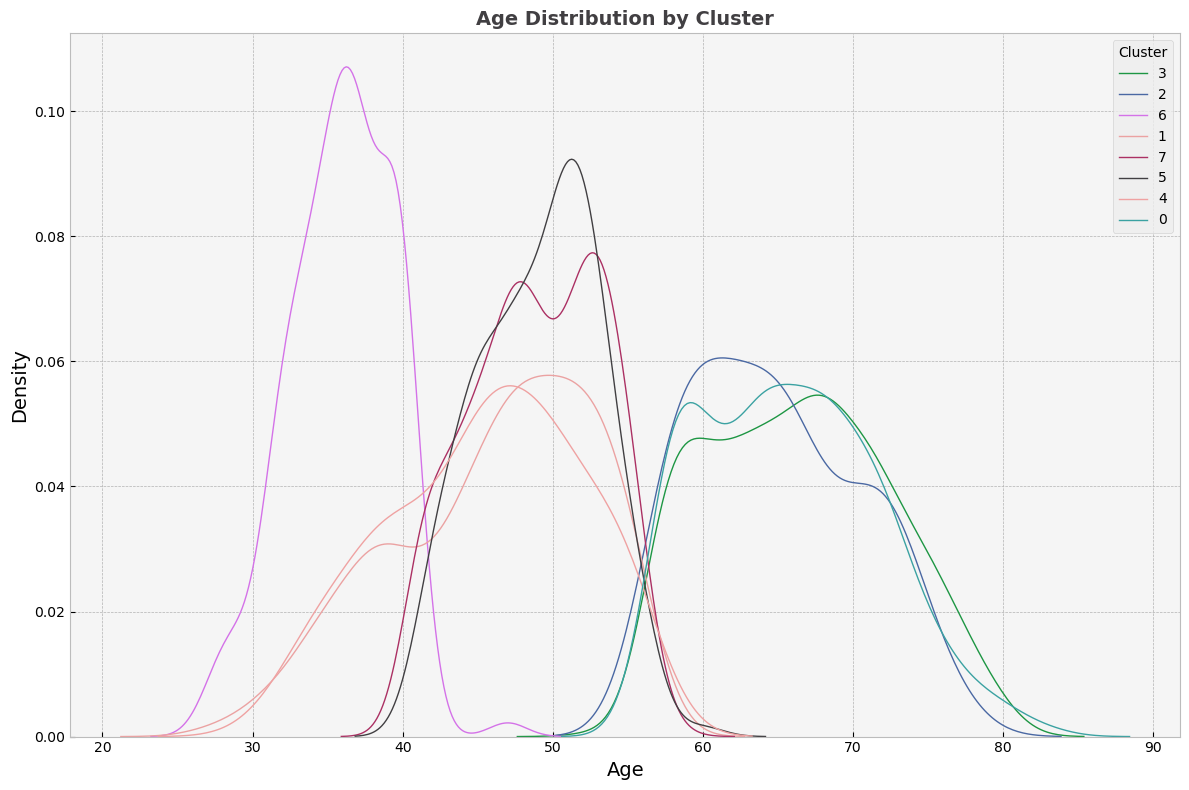

In [60]:
df['Umap_Cluster'] = labels_opt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Age Distribution by Cluster', fontsize=14, fontweight='semibold', color="#413f42")
ax.set_facecolor('#f5f5f5')
# clusters = [0, 1, 2, 3, 4, 5]
clusters = df[df['Umap_Cluster']!=-1]['Umap_Cluster'].unique()
colors = ['#1d9643', '#4a68a3', '#d472e8', '#eba2a2', '#ab3063', '#413f42', '#efa2a2', '#3ba2a2']

for segment, color in zip(clusters, colors):
    sns.kdeplot(data=df[df['Umap_Cluster'] == segment]['Age'], color=color, ax=ax, label=segment, linewidth=1)

ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend(loc='upper right', title='Cluster')
plt.tight_layout()
plt.show()
                

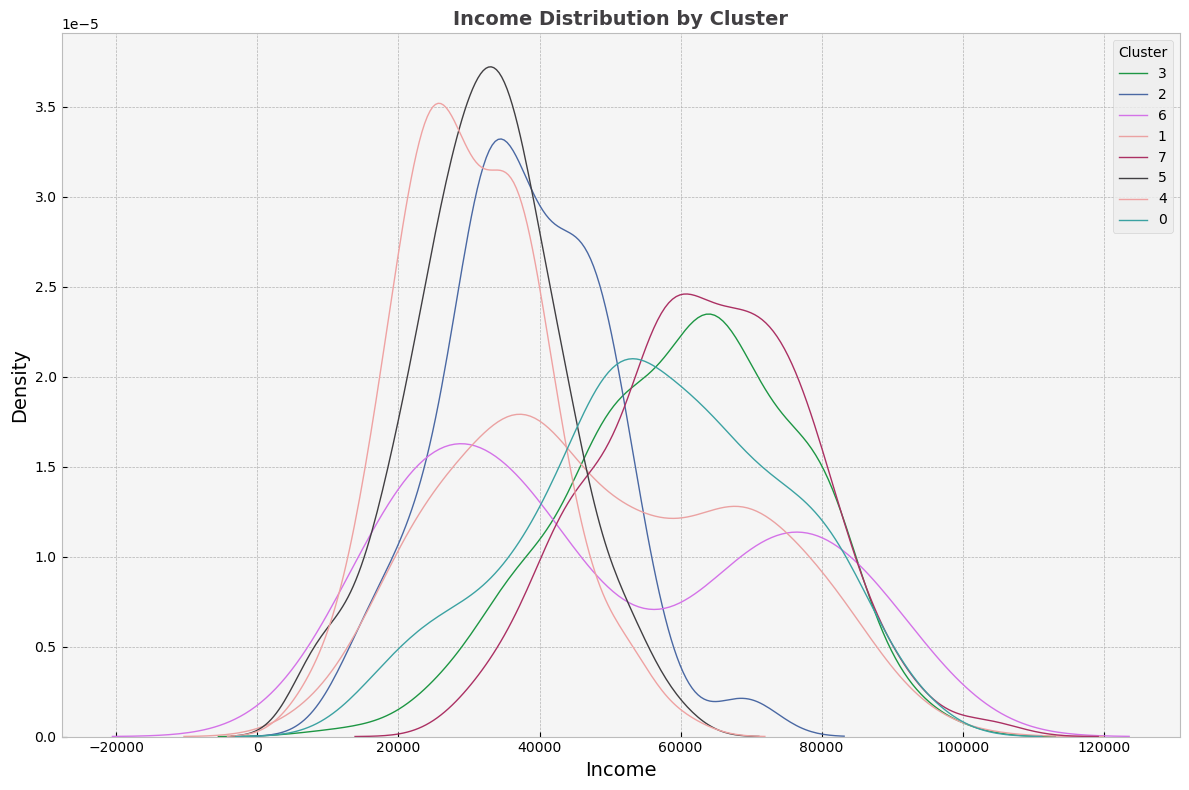

In [70]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Income Distribution by Cluster', fontsize=14, fontweight='semibold', color="#413f42")
ax.set_facecolor('#f5f5f5')
# clusters = [0, 1, 2, 3, 4, 5]
clusters = df[df['Umap_Cluster']!=-1]['Umap_Cluster'].unique()
colors = ['#1d9643', '#4a68a3', '#d472e8', '#eba2a2', '#ab3063', '#413f42', '#efa2a2', '#3ba2a2']

for segment, color in zip(clusters, colors):
    sns.kdeplot(data=df[df['Umap_Cluster'] == segment]['Income'], color=color, ax=ax, label=segment, linewidth=1)

ax.set_xlabel('Income', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend(loc='upper right', title='Cluster')
plt.tight_layout()
plt.show()
                

In [69]:
#create crosstab where umap_cluster==5 with is_parent and RFM_Segment
pd.crosstab(df['Umap_Cluster'], df['RFM_Segment'], normalize='index')


RFM_Segment,At Risk,Can't Lose,Champions,Lost,New,Promising
Umap_Cluster,,,,,,
0,0.176796,0.698895,0.000000,0.124309,0.000000,0.000000
1,0.230620,0.542636,0.001938,0.224806,0.000000,0.000000
2,0.000000,0.000000,0.012048,0.000000,0.987952,0.000000
3,0.000000,0.000000,0.835991,0.000000,0.034169,0.129841
4,0.000000,0.000000,0.039370,0.000000,0.000000,0.960630
5,0.000000,0.000000,0.015625,0.000000,0.984375,0.000000
6,0.000000,0.000000,0.503448,0.000000,0.496552,0.000000
7,0.000000,0.000000,0.993921,0.000000,0.006079,0.000000


In [68]:
pd.crosstab(df['Umap_Cluster'], df['Generation'], normalize='index')


Generation,Baby_Boomers,Generation_X,Millennials,Silent_Generation
Umap_Cluster,,,,
0,0.941989,0.002762,0.000000,0.055249
1,0.001938,0.759690,0.238372,0.000000
2,0.975904,0.000000,0.000000,0.024096
3,0.922551,0.002278,0.000000,0.075171
4,0.000000,0.755906,0.244094,0.000000
5,0.010417,0.989583,0.000000,0.000000
6,0.000000,0.034483,0.965517,0.000000
7,0.003040,0.993921,0.003040,0.000000
